## Advantage Actor-Critic (A2C)

In [100]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.optim import Adam
from torch.distributions import Categorical

In [ ]:
env = gym.make('CartPole-v1')

env.reset()

In [102]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.lin1 = Linear(4, 25)
        self.lin2 = Linear(25, 50)
        self.actor_lin1 = Linear(50, 2)
        self.lin3 = Linear(50, 25)
        self.critic_lin1 = Linear(25, 1)
    
    def forward(self, x):
        # Policy network
        x = F.normalize(x, dim = 0)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        action_probs = F.log_softmax(self.actor_lin1(x), dim = 0)
        # Critic
        state_values = F.relu(self.lin3(x.detach()))
        state_values = torch.tanh(self.critic_lin1(state_values))
        return action_probs, state_values

gpu = torch.device('cuda:0')    
    
actor_critic = ActorCritic().to(gpu)

optimizer = Adam(actor_critic.parameters(), lr = 1e-4)

In [103]:
def run_episode(env):
    '''
    Run one episode in environment with given model. Returns state values,
    log probabilities and rewards from one episode.
    '''
    # Get current state
    state = torch.from_numpy(np.array(env.state)).to(gpu, dtype = torch.float)
    state_values = []
    logprobs = []
    rewards = []
    finished = False
    # ----------------- Episode starts -----------------
    while finished == False:
        # Compute action probabilities and state value
        policy, state_value = actor_critic(state)
        state_values.append(state_value)
        # Select an action
        action = Categorical(logits = policy.view(-1)).sample()
        logprob = policy.view(-1)[action]
        logprobs.append(logprob)
        # Take the action
        state_new, _, finished, _ = env.step(action.detach().cpu().numpy())
        # Update state
        state = torch.from_numpy(state_new).to(gpu, dtype = torch.float)
        # Check if game was lost
        if finished == True:
            reward = -10
            env.reset()
        else:
            reward = 1.0
        rewards.append(reward)
    # ----------------- Episode ends -----------------
    return state_values, logprobs, rewards

def update_params(state_values, logprobs, rewards, c_scale = 0.1, discount = 0.95):
    '''
    Updates model parameters based on one episode. Returns actor loss, critic loss
    and length of episode. Scales critic loss by 0.1 because we want actor to learn
    faster than critic.
    '''
    # Reverse order and flatten inputs
    rewards = torch.Tensor(rewards).flip(dims = (0,)).view(-1)
    logprobs = torch.stack(logprobs).flip(dims = (0,)).view(-1).to(gpu, dtype = torch.float)
    state_values = torch.stack(state_values).flip(dims = (0,)).view(-1)
    len_episode = len(rewards)
    # Compute returns (discounted rewards)
    returns = []
    return_ = torch.Tensor([0])
    for i in range(len(rewards)):
        return_ = rewards[i] + discount * return_
        returns.append(return_)
    returns = torch.stack(returns).view(-1).to(gpu, dtype = torch.float)
    returns = F.normalize(returns, dim = 0)
    # Compute loss
    actor_loss = -1 * logprobs * (returns - state_values.detach())
    critic_loss = torch.pow(state_values - returns, 2) 
    loss = actor_loss.sum() + c_scale * critic_loss.sum()
    # Update model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    return actor_loss, critic_loss, len_episode

In [104]:
num_games = 4_000
len_episodes = []
losses_actor = []
losses_critic = []

for i_game in range(num_games):    
    state_values, logprobs, rewards = run_episode(env)
    actor_loss, critic_loss, episode_len = update_params(state_values, logprobs, rewards)
    losses_actor.extend(actor_loss.detach().cpu().numpy())
    losses_critic.extend(critic_loss.detach().cpu().numpy())
    len_episodes.append(episode_len)
    if i_game % 500 == 0:
        print(f'Game: {i_game:04d} | Avg. game length: {np.mean(len_episodes):.2f}')

Game: 0000 | Avg. game length: 19.00
Game: 0500 | Avg. game length: 26.93
Game: 1000 | Avg. game length: 35.79
Game: 1500 | Avg. game length: 52.56
Game: 2000 | Avg. game length: 76.90
Game: 2500 | Avg. game length: 103.60
Game: 3000 | Avg. game length: 130.46
Game: 3500 | Avg. game length: 154.15


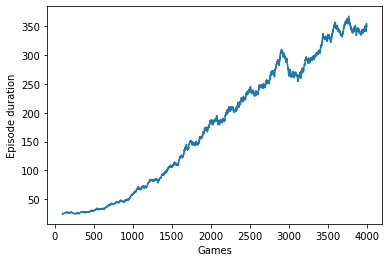

In [105]:
len_episodes = pd.Series(len_episodes).rolling(100).mean()

plt.plot(len_episodes)
plt.ylabel('Episode duration')
plt.xlabel('Games');

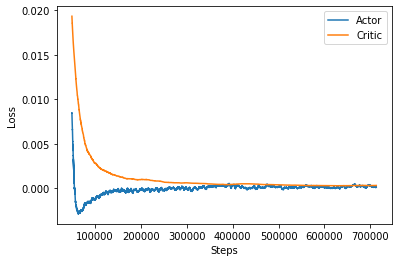

In [110]:
losses_actor = pd.Series(losses_actor).rolling(50_000).mean()
losses_critic = pd.Series(losses_critic).rolling(50_000).mean()

plt.plot(losses_actor)
plt.plot(losses_critic)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend(['Actor', 'Critic'], loc = 'upper right');

In [119]:
env.reset()
for i in range(1_000):
    state = torch.from_numpy(np.array(env.state)).to(gpu, dtype = torch.float)
    logits, value = actor_critic(state)
    action = torch.distributions.Categorical(logits = logits).sample()
    _, _, finished, _ = env.step(action.detach().cpu().numpy())
    if finished == True:
        print("Lost")
        env.reset()
    state_new = np.array(env.state)
    state = torch.from_numpy(state_new).float()
    env.render()

Lost
Lost


In [120]:
env.close()

## N-step Actor-Critic

In [201]:
def run_episode(env, n_steps = 10):
    '''
    Run one episode in environment with given model. Returns state values,
    log probabilities and rewards from one episode. Runs only for N steps
    at most.
    '''
    # Get current state
    state = torch.from_numpy(np.array(env.state)).to(gpu, dtype = torch.float)
    state_values = []
    logprobs = []
    rewards = []
    return_last = torch.Tensor([0])
    finished = False
    i_step = 0  
    while i_step < n_steps and finished == False:
        i_step += 1
        # Compute action probabilities and state value
        policy, state_value = actor_critic(state)
        state_values.append(state_value)
        # Select action
        action = Categorical(logits = policy.view(-1)).sample()
        # Take action
        logprob = policy.view(-1)[action]
        logprobs.append(logprob)
        state_new, _, finished, _ = env.step(action.detach().cpu().numpy())
        # Update state
        state = torch.from_numpy(state_new).to(gpu, dtype = torch.float)
        # Check if game was lost
        if finished == True:
            reward = -10
            env.reset()
        # If not finished, set return to last value
        else:
            reward = 1.0
            return_last = state_value.detach()
        rewards.append(reward)
    return state_values, logprobs, rewards, return_last

def update_params(state_values, logprobs, rewards, return_last, c_scale = 0.1, discount = 0.95):
    '''
    Updates model parameters based on one episode. Returns actor loss, critic loss
    and length of episode. Scales critic loss by 0.1 because we want actor to learn
    faster than critic.
    '''
    # Reverse order and flatten inputs
    rewards = torch.Tensor(rewards).flip(dims = (0,)).view(-1)
    logprobs = torch.stack(logprobs).flip(dims = (0,)).view(-1).to(gpu, dtype = torch.float)
    state_values = torch.stack(state_values).flip(dims = (0,)).view(-1)
    len_episode = len(rewards)
    # Compute returns (discounted rewards)
    returns = []
    return_ = return_last
    for i in range(len(rewards)):
        return_ = rewards[i] + discount * return_
        returns.append(return_)
    returns = torch.stack(returns).view(-1).to(gpu, dtype = torch.float)
    returns = F.normalize(returns, dim = 0)
    # Compute loss
    actor_loss = -1 * logprobs * (returns - state_values.detach())
    critic_loss = torch.pow(state_values - returns, 2) 
    loss = actor_loss.sum() + c_scale * critic_loss.sum()
    # Update model parameters
    #optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    return actor_loss, critic_loss, len_episode

def evaluate():
    '''
    Tests current model in a test environment. Returns number of steps taken before losing.
    '''
    test_env = gym.make("CartPole-v1")
    test_env.reset()
    num_steps = 0
    finished = False
    state = torch.from_numpy(np.array(test_env.state)).to(gpu, dtype = torch.float)
    while(finished == False):
        policy, state_value = actor_critic(state)
        action = Categorical(logits = policy.view(-1)).sample().detach().cpu().numpy()
        state_new, _, finished, _ = test_env.step(action)
        state = torch.from_numpy(state_new).to(gpu, dtype = torch.float)
        num_steps += 1
    test_env.close()
    return num_steps

In [202]:
env.reset()

actor_critic = ActorCritic().to(gpu)

optimizer = Adam(actor_critic.parameters(), lr = 1e-4)

In [203]:
num_games = 50_000
len_episodes = []
losses_actor = []
losses_critic = []
maxrun = 1

for i_game in range(num_games):   
    optimizer.zero_grad()
    state_values, logprobs, rewards, return_last = run_episode(env)
    actor_loss, critic_loss, episode_len = update_params(state_values, logprobs, rewards, return_last)
    losses_actor.extend(actor_loss.detach().cpu().numpy())
    losses_critic.extend(critic_loss.detach().cpu().numpy())
    if i_game % 50 == 0:
        len_episode = evaluate()
        len_episodes.append(len_episode)
    if i_game % 10_000 == 0:
        print(f'Game: {i_game:04d} | Avg. game length: {np.mean(len_episodes[-200:]):.2f}')

Game: 0000 | Avg. game length: 17.00
Game: 10000 | Avg. game length: 129.34
Game: 20000 | Avg. game length: 364.19
Game: 30000 | Avg. game length: 426.92
Game: 40000 | Avg. game length: 443.58


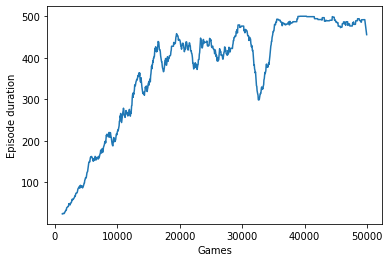

In [214]:
len_episodes_ = pd.Series(len_episodes).rolling(25).mean()

plt.plot(range(0, 50_000, 50), len_episodes_)
plt.ylabel('Episode duration')
plt.xlabel('Games');

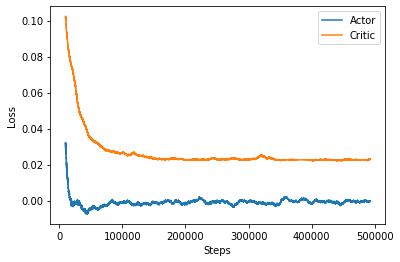

In [220]:
losses_actor = pd.Series(losses_actor).rolling(10_000).mean()
losses_critic = pd.Series(losses_critic).rolling(10_000).mean()

plt.plot(losses_actor)
plt.plot(losses_critic)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend(['Actor', 'Critic'], loc = 'upper right');

In [217]:
env.reset()
steps_taken = 0

for i in range(1_000):
    state = torch.from_numpy(np.array(env.state)).to(gpu, dtype = torch.float)
    logits, value = actor_critic(state)
    action = torch.distributions.Categorical(logits = logits).sample()
    _, _, finished, _ = env.step(action.detach().cpu().numpy())
    steps_taken += 1
    if finished == True:
        print('Lost', steps_taken)
        steps_taken = 0
        env.reset()
    state_new = np.array(env.state)
    state = torch.from_numpy(state_new).float()
    env.render()
    
env.close()

Lost 456
Lost 413
